<a href="https://colab.research.google.com/github/SiyiTang/LearningProcess/blob/main/MyPortfolio%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install deepdow

     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 14.2MB 254kB/s 
     |████████████████████████████████| 1.1MB 47.3MB/s 
     |████████████████████████████████| 153kB 37.0MB/s 
     |████████████████████████████████| 163kB 37.3MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 378kB 28.8MB/s 
     |████████████████████████████████| 2.2MB 33.9MB/s 
     |████████████████████████████████| 1.3MB 31.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
  Created wheel for cvxpy: filename=cvxpy-1.1.12-cp37-cp37m-linux_x86_64.whl size=2731675 sha256=d632af636f9025c3bd7ec452e29646b2cae2fa2a36c0c54145e5db57eed2fa15
  Stored in directory: /root/.cache/pip/wheels/9b/

# Imports and Configuration

In [2]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random, Singleton
from deepdow.callbacks import EarlyStoppingCallback, TensorBoardCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.experiments import Run
from deepdow.nn import KeynesNet
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web

# Initialize

In [3]:
# 获取默认图形尺寸
default_figsize = plt.rcParams["figure.figsize"]

In [4]:
# set random seed for repeatility
torch.manual_seed(4)
np.random.seed(5)

# Data Preprocess

In [7]:
# set start and end time
start = datetime.datetime(2010, 1, 1) 
end = datetime.datetime(2020, 12, 31)

# Which stocks to use: 京东方、格力电器、平安银行、长江电力
# tickers = ['000725.SZ', '000651.SZ', '000001.SZ','600900.SS']
tickers = ['AAPL','NFLX','AMZN','KO']
# fetch close price
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Close']]

In [9]:
# Re-structure the columns
raw_df.columns = pd.MultiIndex.from_product([tickers, ["Close"]], names=["Ticker", "Attribute"]
)
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)
raw_df.head()

Ticker,AAPL,NFLX,AMZN,KO
Attribute,Close,Close,Close,Close
Date,,,,
2010-01-04,7.643214,7.640000,133.899994,28.520000
2010-01-05,7.656429,7.358571,134.690002,28.174999
2010-01-06,7.534643,7.617143,132.250000,28.165001
2010-01-07,7.520714,7.485714,130.000000,28.094999
2010-01-08,7.570714,7.614286,133.520004,27.575001


Fill in with pandas-defined business days since that's used in DeepDow. Use ffill and bfill to copy the previous/next day's closing price assuming no change on days not provided from source.

Note: Chinese trading days are different than pandas business days

In [10]:
index = pd.date_range(start=raw_df.index[0], end=raw_df.index[-1], freq="B")

print(f"Num records before fill: {len(raw_df)}")
raw_df = pd.DataFrame(raw_df, index=index).ffill().bfill()
print(f"Num records after fill: {len(raw_df)}")

Num records before fill: 2769
Num records after fill: 2869


# Creat Database

Derive some parameters for use in creating datasets

In [11]:
n_timesteps = len(raw_df)
n_channels = len(raw_df.columns.levels[1])
n_assets = len(raw_df.columns.levels[0])

In [12]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 2869
Channels = 1
Assets = 4


In [13]:
lookback = 50  # Number of timesteps to look back, e.g. length of X in time
gap = 1  # Gap between end of X and start of y for each data sample
horizon = 5  # Number of timesteps to use for prediction

Generate the splits for train and test

In [14]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(
    raw_df, lookback=lookback, gap=gap, freq="B", horizon=horizon
)

In [15]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

2813

In [16]:
split_ix = int(n_samples * 0.9)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:2530
Test range: 2586:2812


Convert `Xy` format to `InRAMDDataset` for loadin during training.

In [17]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Create a data loader for training from the dataset: 
* one for train
* one for test

In [18]:
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=64)

dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=64)

Print a sample to get acquainted with the format

In [19]:
X_batch, y_batch, timestamps_batch, asset_names_batch = next(iter(dataloader_test))
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")
print(f"Asset names: {asset_names_batch}")
print(f"Num Timestamps: {len(timestamps_batch)}, sample: {timestamps_batch[0]}")

X_batch shape: torch.Size([64, 1, 50, 4])
y_batch shape: torch.Size([64, 1, 5, 4])
Asset names: ['AAPL', 'AMZN', 'KO', 'NFLX']
Num Timestamps: 64, sample: 2020-03-16 00:00:00


In [20]:
loaders = {"train": dataloader_train, "test": dataloader_test}
date_ranges = {}
for label, d in loaders.items():
    minval = pd.Timestamp("2100-01-01 00:00:00", freq="B")
    maxval = pd.Timestamp("1970-01-01 00:00:00", freq="B")
    for _,_,c,_ in d:
        if min(c) < minval:
            minval = min(c)
        if max(c) > maxval:
            maxval = max(c)        
    date_ranges[label] = (minval, maxval)
    
print("Date ranges for each dataset:\n")
print(*[f"{k}: {v}\n" for k,v in date_ranges.items()])

Date ranges for each dataset:

train: (Timestamp('2010-03-15 00:00:00', freq='B'), Timestamp('2019-11-25 00:00:00', freq='B'))
 test: (Timestamp('2020-02-11 00:00:00', freq='B'), Timestamp('2020-12-23 00:00:00', freq='B'))



# Creat Network

In [21]:
network = KeynesNet(1,hidden_size=64)
print(network)

KeynesNet(
  (transform_layer): RNN(
    (cell): LSTM(1, 64)
  )
  (norm_layer_1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 64, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [22]:
network = network.train()

In [23]:
loss =SharpeRatio()

In [24]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss', dataloader_name='test', patience=15)
                  ])

## Train the network

In [25]:
history = run.launch(30)

Epoch 29: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s, loss=-0.18025, test_loss=-0.17288]


In [26]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # 计算每个周期样本数量
print(per_epoch_results.mean())  # 计算每个epoch的平均loss

dataloader  metric  model    epoch
test        loss    network  0        227
                             1        227
                             2        227
                             3        227
                             4        227
                             5        227
                             6        227
                             7        227
                             8        227
                             9        227
                             10       227
                             11       227
                             12       227
                             13       227
                             14       227
                             15       227
                             16       227
                             17       227
                             18       227
                             19       227
                             20       227
                             21       227
                             22       227

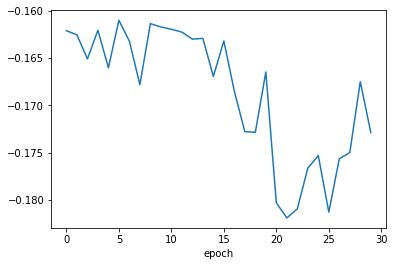

In [27]:
per_epoch_results.mean()['test']['loss']['network'].plot()

In [28]:
network = network.eval()

In [29]:
# Assign benchmarks. Recall: IBM does poorly. Amazon does well.
# First add the individual stocks
benchmarks = {asset_name: Singleton(asset_ix=i) for i, asset_name in enumerate(asset_names_batch)}

# Now add the others
benchmarks["1overN"] = OneOverN()  # each asset has weight 1 / n_assets
benchmarks["random"] = Random()  # random allocation that is however close 1OverN
benchmarks["network"] = network  # our trained network

# Include metrics. Selected two, since using only one bombs out at time of writing
# NOTE: We are using `simple` here for the mean return, whereas most of the training and data config above is in log-space by default.
metrics = {
    "Sharpe": SharpeRatio(),
    "MeanReturn": MeanReturns(output_type="simple"),
    "MaxDD": MaximumDrawdown(),
}


In [30]:
metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)

In [31]:
metrics_table['value'] *= -1

In [32]:
metrics_table.tail()

,timestamp,benchmark,metric,value
30,2020-02-25,network,MaxDD,-0.020650
31,2020-11-03,network,MaxDD,-0.000807
32,2020-03-05,network,MaxDD,-0.124556
33,2020-09-18,network,MaxDD,-0.035949
34,2020-04-09,network,MaxDD,-0.015306


/usr/local/lib/python3.7/dist-packages/deepdow/visualize.py:177: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd50f02f790>,
      dtype=object)

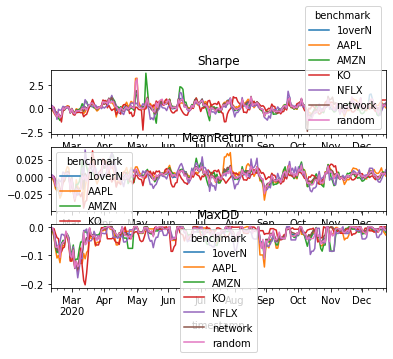

In [33]:
plot_metrics(metrics_table)

In [34]:
weight_table = generate_weights_table(network, dataloader_test)
weight_table

,AAPL,AMZN,KO,NFLX
2020-02-11,0.503069,0.156258,0.209786,0.130887
2020-02-12,0.516011,0.167123,0.185173,0.131693
2020-02-13,0.397813,0.289646,0.181222,0.131318
2020-02-14,0.378247,0.288146,0.200564,0.133043
2020-02-17,0.397192,0.271860,0.200256,0.130693
...,...,...,...,...
2020-12-17,0.266953,0.209634,0.315935,0.207479
2020-12-18,0.288560,0.230919,0.255846,0.224675
2020-12-21,0.289785,0.250801,0.216352,0.243062
2020-12-22,0.264279,0.228527,0.286795,0.220398


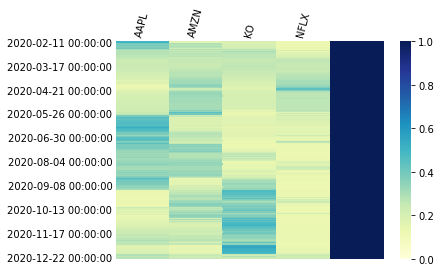

In [35]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [36]:
benchmark_num = metrics_table['benchmark'].unique()
metric_num = metrics_table['metric'].unique()

In [37]:
df2=pd.DataFrame(np.random.randn(len(benchmark_num),len(metric_num)),
                 index=list(benchmark_num),
                 columns=list(metric_num))
for i in benchmark_num:
  for j in metric_num:
    returns = metrics_table.query(f"(metric=='{j}') & (benchmark == '{i}')")
    index_num=list(benchmark_num).index(i)
    column_num=list(metric_num).index(j)
    df2.iloc[index_num][column_num]=returns['value'].mean()
    #print(index_num,column_num,returns['value'].mean())
print(df2)




           Sharpe  MeanReturn     MaxDD
AAPL     0.186884    0.002677 -0.031108
AMZN     0.139380    0.002152 -0.028824
KO       0.045316   -0.000165 -0.027647
NFLX     0.082009    0.001845 -0.034437
1overN   0.161869    0.001617 -0.024068
random   0.166052    0.001576 -0.025050
network  0.172878    0.001711 -0.023754
